# Week 8 Lab

In [1]:
%pylab inline

from sympy import *
init_printing(use_unicode = True, fontsize = 16)

pi2 = pi * 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys 

if os.name == 'nt':
    path = 'C:\\Users\\Wei\\Dropbox\\Coding\\notebooks\\專案\\待處理\\Waves\\bitbucket\\github\\codes'
else:
    path = '/home/wei/Dropbox/Coding/notebooks/專案/待處理/Waves/bitbucket/github/codes'
    
sys.path.append(path)
 
from thinkx import * 
from waves.sound import * 
from waves.tools.dsp import * 
from waves.tools.dsp.sampling import * 
from waves.tools.dsp.interpolator import * 

## Signal of the Day: Moire Patterns
$$
\begin{align}
x[n] &= cos(\omega_1 n) + cos(\omega_2 n) \\
&= 2cos(\frac{\omega_1-\omega_2}{2} n )cos(\frac{\omega_1+\omega_2}{2} n ) \\
&\approx 2cos(\Delta_\omega n) cos( \omega_1  n ) \\
\end{align}
$$

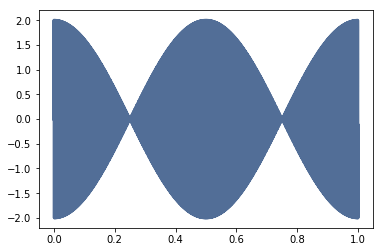

In [3]:
f1 = 440
f2 = f1 + 2
s1 = thinkdsp.SinSignal(f1)
s2 = thinkdsp.SinSignal(f2)
ss = thinkdsp.SumSignal(s1, s2)
w = ss.make_wave(framerate = DEFAULT_FRAMERATE)
w.plot()

### Moire and Aliasing: 1D example

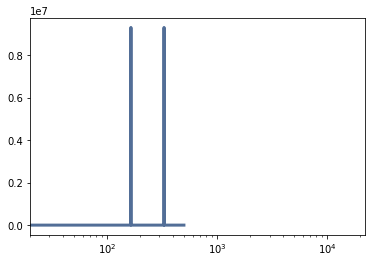

In [4]:
f1 = 165
f2 = f1 * 2
s1 = thinkdsp.SinSignal(f1)
s2 = thinkdsp.SinSignal(f2)
ss = thinkdsp.SumSignal(s1, s2)
w = ss.make_wave(framerate = 1000)
ch = Channel.load_thinkdsp_wave(w)
ch.make_spectrum().plot()

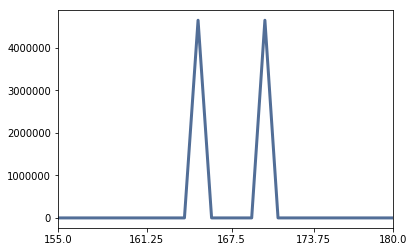

In [5]:
ys = w.ys[::2]
ch = Channel(ys, framerate= 500)  # down sample and the hight frequency will fold back to form beating.
ch.make_spectrum().plot()
xticks = np.linspace(155, 180, 5)
plt.xlim((155, 180))
plt.xticks(xticks, xticks);

In [6]:
tb = ch.make_spectrum()
tb.rank_by_amps()[0][:2]

array([165., 170.])

## 6.2.a Upsampling

To upsample a sequence by a factor of KK, we can implement this in the digital-domain by

- inserting $K-1$ zeros between consecutive samples
- filtering the result with an ideal lowpass filter with cutoff frequency $\frac{\pi}{K} $  

This produces exactly the same result as the operation via the continuous-time domain. Moreover, to recover the original sequence from the up sampled one, we can simply discard all coefficients that are not integer multiple of K.

眾多以n $(n \in \mathbb{Z})$ 為中心的sinc波形 $sinc(\frac{t}{Ts} -n)$ 形成 Hilbert space 的一組 basis  


#### Analysis (sampling) formula:  
$$x[n] = <x(t), sinc(\frac{t}{Ts} -n)> = Ts \times x(nTs)$$  

#### Synthesis (reconstruction) formula:  
$$x(t) = \frac{1}{Ts}\sum_{n= -\infty}^{\infty} x[n] sinc(\frac{t}{Ts} -n)$$  


#### Re-sampling (operation via the continuous-time domain):  

$$
\begin{align}
x[m] &= original \space descrete \space signal \\
Ts & = interpolation (sampling) \space interval \\ 
x_c(t) &= \frac{1}{Ts} \sum_{m = -\infty}^{\infty} x[m]sinc(\frac{t}{Ts} - m) \\
resample \space interval &=   \frac{Ts}{K} \\ 
x^{\prime}[n] = x_c(n \frac{Ts}{K}) &=\frac{1}{Ts}   \sum_{m = -\infty}^{\infty} x[m]sinc(\frac{n \frac{Ts}{K}}{Ts} - m) \\
&=  \frac{1}{Ts} \sum_{m= -\infty}^{\infty} x[m] sinc(\frac{n }{K } - m) & ------(1) \\
\end{align}
$$

- 由 $x[n]$ 做 Interpolation 成為 $x(t)$, 和由 $x[n]$ 做 re-sampling 成為 $x^{\prime}[n]$ 都是一種 interpolation 的過程。
- 以 K 倍率做 re-sampling，相當於把 原本的 x[m] 對以$\frac{n }{K }$為中心的$ sinc()$ function 做 convolution
- resampling 可視為一種 convolution 的動作
- 既然等同於 convolution，那麼就可以用 FIR filter 來達到 resampling 的效果
- 取樣的 Ts 變小，相當於 $\Omega_N $變大
- Ts 變成 1/K，表示時間上的解析度變高，可以表達的頻率範圍變大，$\Omega_N$ 變成 K 倍
- Ts 變成 1/K，但原本訊號 x 的時間總長並不變，所以雖然經過 re-sampling 所含的頻率 (Hz) 並不變，但是 $\Omega_N$ 已經變成 K 倍。
- 當 resample 之後，離散訊號中所代表的 frequency 不變，但是頻率範圍會由 $\Omega_N$ 變成 $\pi$。
- K的倍數越大，相當於原本訊號被壓縮到更小的離散頻率範圍。
- re-sampling 之後的 $x^{\prime}[n]$ 是一個 descrete time signal，所代表的頻率範圍是 $-\pi \to \pi$，所以是經過 K倍壓縮的。
  - $\pi \Rightarrow \Omega_N $ ; 離散的 $\pi$ 相當於 $\Omega_N$
  - $\Omega_N   \times  K = K\Omega_N $ ;   $\Omega_N$ 放大 K 倍
  - $K\Omega_N \Rightarrow \pi $ ; K 倍的$\Omega_N$ 相當於 $\pi$，原本的頻譜內容被壓所到一個較小的頻率範圍中。

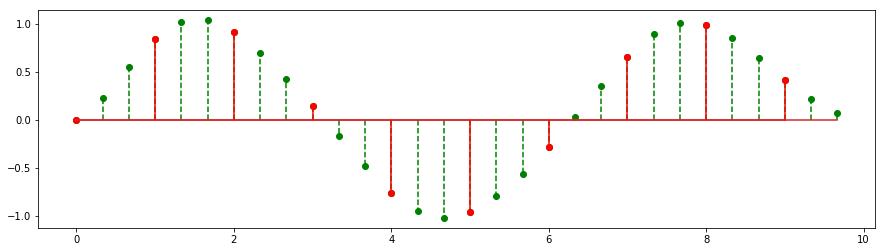

In [7]:
from waves.tools.dsp.interpolator import *


t = np.arange(10)

x = np.sin(t)
K = 3
n, x1 = Multirate.upsample(x, K)

plt.figure(figsize = (15, 4))
plt.stem(n, x1, linefmt = 'g--', markerfmt = 'go')
plt.stem(t, x, linefmt = 'r-', markerfmt = 'ro')
plt.show()

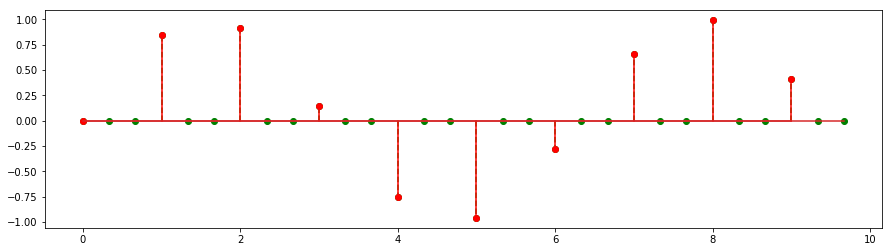

In [8]:
# 使用 EPFL 提供的 multirate.upsample 函數，只會等距插入 K-1 個 0

from waves.tools.dsp.sampling import *


t = np.arange(10)

x = np.sin(t)
K = 3
x1 = multirate.upsample(x, K)

plt.figure(figsize = (15, 4))
plt.stem(np.arange(len(x1))/K,  x1, linefmt = 'g--', markerfmt = 'go')
plt.stem(t, x, linefmt = 'r-', markerfmt = 'ro')
plt.show()

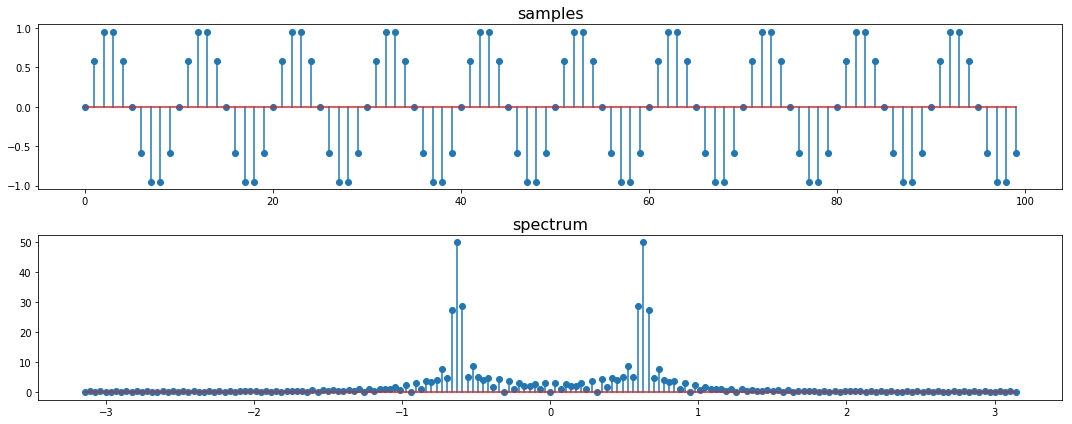

In [9]:
s = thinkdsp.SinSignal(10)
w = s.make_wave(duration = 1, framerate = 100)
YS = fourier.dtft(w.ys)

### up sample 三倍之後：
- 波形看起來一樣，但是 X 軸的長度變為三倍
- 以 descrete 的觀點來看，每一點x之間 y的變化較小，表示表達的能力較強，可以容納與表達的頻率範圍較大
  - 每一點x之間 y的變化較小，表示對於 x軸間隔來說，此訊號的頻率較低
- 對同一個訊號來說，
  - Ts 變小，
  - 做 up sample之後，Ts 變小:
    - $\Omega_N$ 就變大，但是...
    - 做 DTFT 之後 解析出來的頻率範圍還是  $ [-\pi , \pi]$ 
    - 訊號顯得行動緩慢，此訊號的頻率在 $ [-\pi , \pi]$ 範圍中出現的位置會縮小，而往中央靠攏。 
  - 所以做 up sample 會將頻譜壓縮。

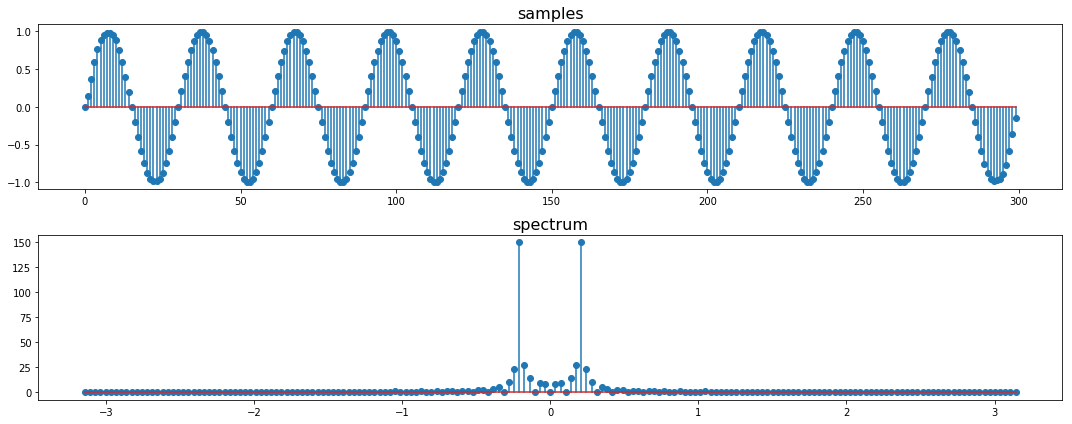

In [10]:
_, ys1 = Multirate.upsample(w.ys, 3)
YS1 = fourier.dtft(ys1)

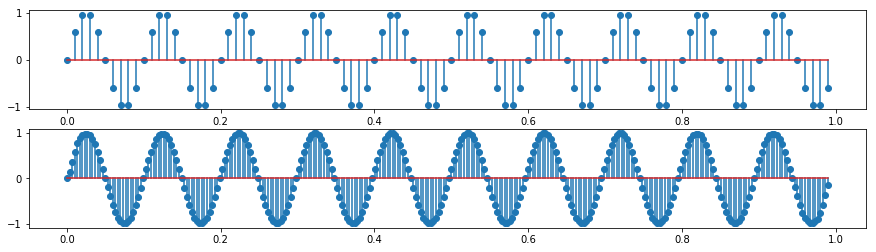

In [11]:
# 測試 scale_t 的功能

plt.figure(figsize = (15, 4))
plt.subplot(2, 1, 1)
plt.stem(w.ts, w.ys)
plt.subplot(2, 1, 2)
plt.stem(Multirate.scale_t(w.ts, K), ys1);  # 測試 scale_t 的功能

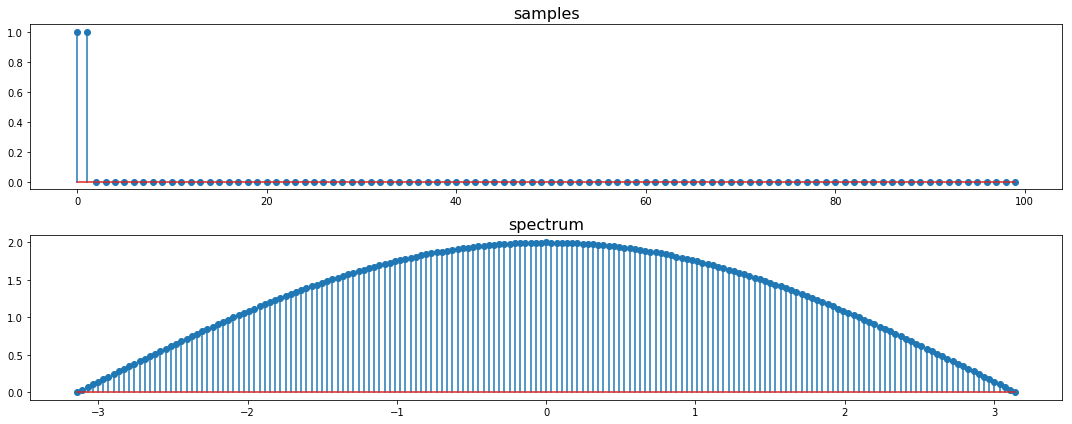

In [12]:
d = np.zeros(100)
d[:2] =1
D = fourier.dtft(d)

### 如果有 interpolate，則只會出現主頻譜

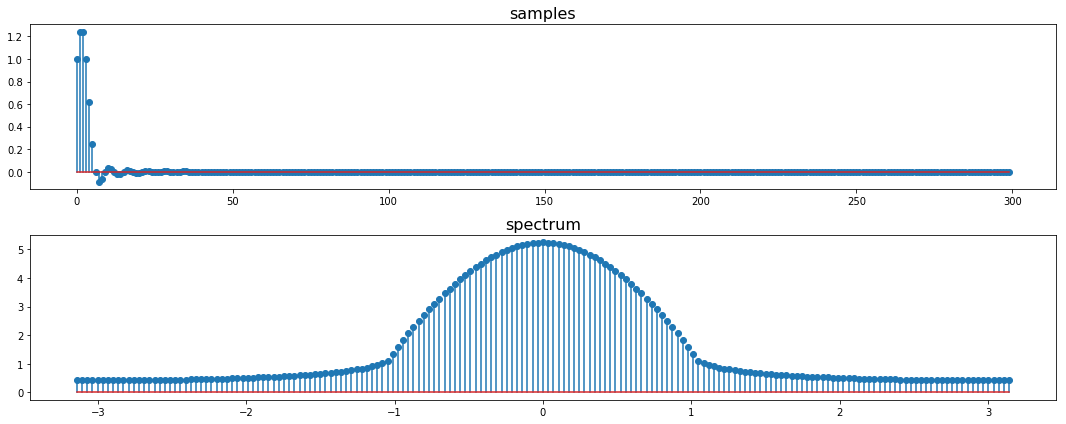

In [13]:
_, d1 = Multirate.upsample(d, 3)
D1 = fourier.dtft(d1)

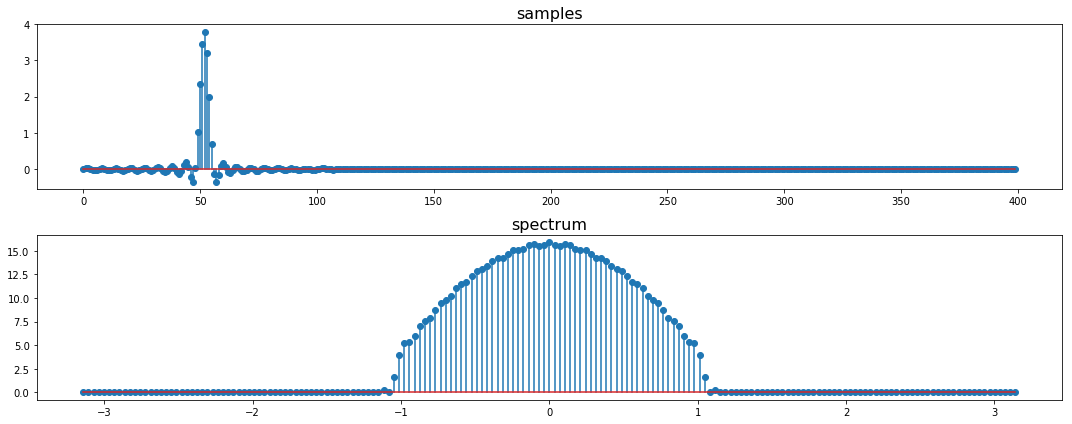

In [14]:
N = len(d) // 2

d2 = np.convolve(d1, np.sinc(np.arange(-N, N+1)/K))
D2 = fourier.dtft(d2)

### 如果只是 插入0做 up sampling，但是沒有 interpolate
- 使用 EPFL 提供的 multirate.upsample 函數，只會等距插入 K-1 個 0
- 則會把 $[-3\pi, 3\pi]$ 範圍內 三倍壓縮成  $[-\pi, \pi]$ ，而出現多個副本頻譜  

$$
\begin{align}
X_U(e^{j\omega}) &= \sum_{m=-\infty}^{\infty} X_U[m] e^{-j\omega m}  &   x_U[m] = 0 \space when \space  m \neq n k  \\
&= \sum_{n=-\infty}^{\infty} X[n] e^{-j\omega nK}  \\
&= X(e^{j\omega K})
\end{align}
$$  

#### 做 K 倍 的 Up sample，其頻譜等於是原來的頻譜作 頻率上的 K 倍壓縮。

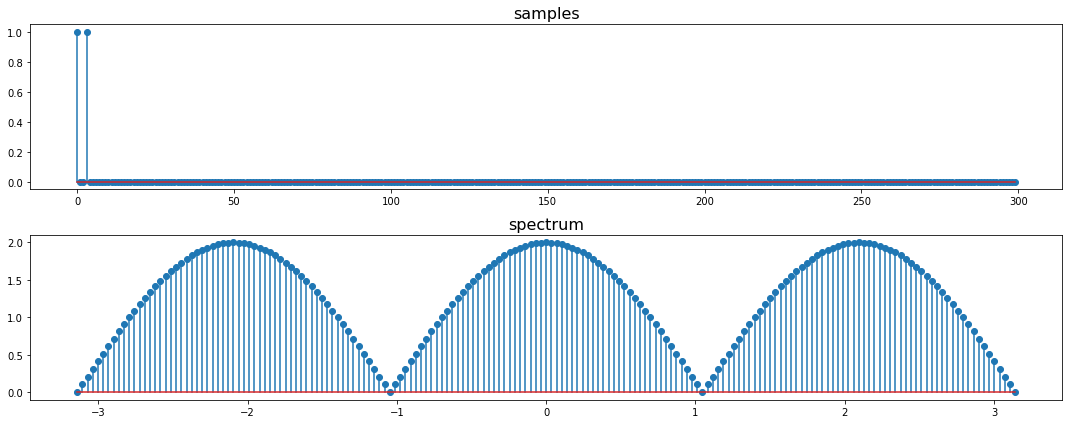

In [15]:
# 使用 EPFL 提供的 multirate.upsample 函數，只會等距插入 K-1 個 0

d1 = multirate.upsample(d, 3)
D1 = fourier.dtft(d1)

### 施加一個 low-pass filter
- 因為 原來做 K=3 的 up sampling
- 現在施以一個 $\omega_{cut} = \frac{\pi}{K}$ 的 low-pass ideal filter
- 等於以 $sinc(\frac{n}{K}) $ 做 convolution，因為 since 的 DTFT 是 rect  

$$
\begin{align}
x^{\prime}[n] &= x_U(n) * sinc(\frac{n}{K})  \\
&= \sum_{i = -\infty}^{\infty} x_U[i] sinc(\frac{n-i}{K})   &   x_U[i] = 0 \space when \space  i \neq m k  \\
&= \sum_{m=-\infty}^{\infty} x[m] sinc(\frac{n}{K} - m)  & ------(2) \\
\end{align}
$$  

公式 (1), (2) 是相同的，所以下述兩者的效果相同:
- 以 $sinc(\frac{n}{K}) $ 對 $x[m]$ 做 convolution 做 up sampling
- 等距插入 k-1 個 0 做 up-sampling 得到 $x_U[n]$ 並以 $sinc(\frac{n}{K}) $ 對 $x_U[n]$ 做 low-pass filtering

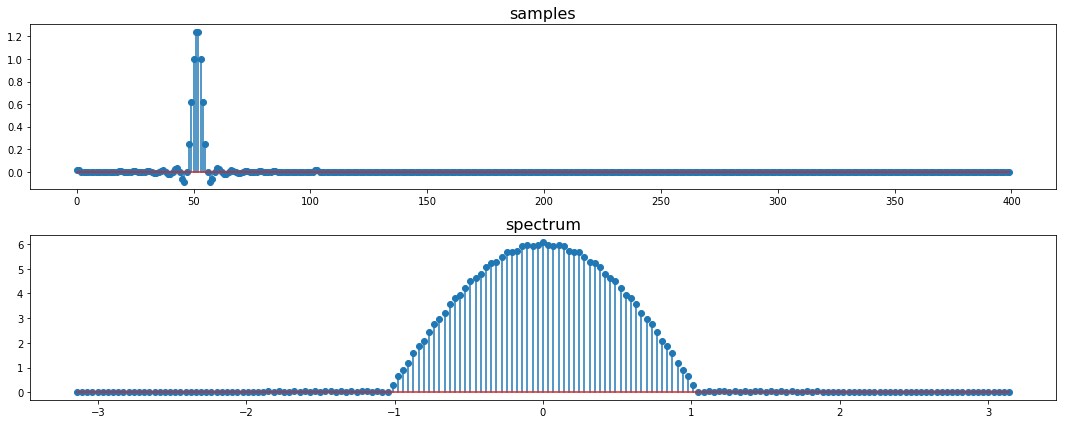

In [16]:
N = len(d) // 2
d2 = np.convolve(d1, np.sinc(np.arange(-N, N+1)/K))  
D2 = fourier.dtft(d2)

/home/wei/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


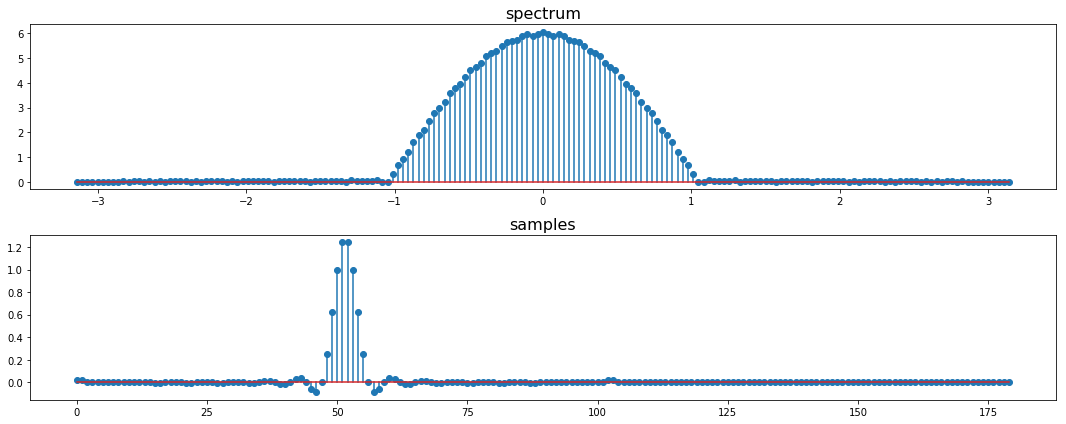

In [17]:
_ = fourier.idtft(D2)

### 所以，只是:
- 等距插入 K-1 個 0 做 K 倍 up sampling 就可將頻譜壓縮，
- 只需要再以  $sinc (\frac{n}{K}) $ 做 convolution 施加 low-pass filter 就可以去除一同被壓縮進來的高頻訊號-

## 6.2.b Fitting the transmitter spectrum
- Given the bandwidth constraint given by $F_{min}$ and $F_{max}$ , 
- let $ W$ be the positive bandwidth $W = F_{max} - F_{min}$ and 
- let us choose the sampling frequency such that $F_s > 2F_{max}$ and
- $F_s = KW$. When we translate this specification in the digital domain, 
- we can simply upsample the original sequence by a factor $K$ to shrink its bandwidth from $2\pi$ to $2\pi/K$. 
- This upsampling operation does not change the data rate and we transmit $W$ symbols per second. 
- $W$, the positive bandwidth of a channel, is referred to as the ***Baud rate*** of the system.

$$
\begin{align}
W &= F_{max} - F_{min}  \\
pick \space F_s &> 2 F_{max}  \\
let \space F_s &= KW  \\
\omega_{max} - \omega_{min} &= 2 \pi \frac{W}{F_s} \\
&= 2\frac{\pi}{K} \\
\end{align}
$$  

Set $F_s = KW$, then we can simply upsample by K.

### Raised Cosine
https://en.wikipedia.org/wiki/Raised-cosine_filter

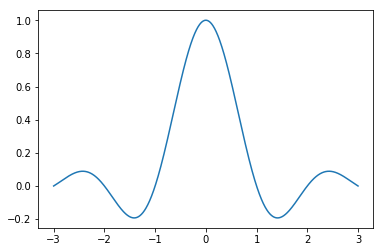

In [18]:
t = np.linspace(-3, 3, 1000)
plt.plot(t, filtering.raised_cosine(t, period = 1, beta = 0.25));

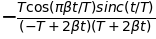

In [19]:
# 用 SymPy 簡化

beta, T, t = symbols('beta, T, t', real = True)

h = Piecewise((pi/(4*T) * sinc(1/(2*beta)), abs(t) == T/(2*beta)), 
              (1/T*sinc(t/T)*cos(pi*beta*t/T)/(1-(2*beta*t/T)**2), True))

h.collect(t).factor()

### 這是以 T (Ts) 為單位的 sinc 函數的變形
- $t = 0$ 的時候，RC 函數的值 = $\frac{T}{T^2} = \frac{1}{T} $
- 每當 t 是 T 的整數倍數的時候，RC = 0

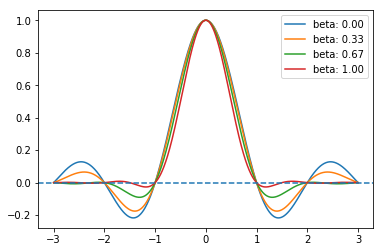

In [20]:
t = np.linspace(-3, 3, 1000)

for b in np.linspace(0, 1, 4):
    plt.plot(t, filtering.raised_cosine(t, period = 1, beta = b), label = 'beta: {:0.2f}'.format(b))
    
plt.axhline(0, ls = '--')
plt.legend();

In [21]:
# 用 SymPy 簡化 h 的頻率響應 H

beta, T, f = symbols('beta, T, f', real = True)

H = Piecewise(( 1/2*(1+cos(pi*T/beta*(abs(f)-(1-beta)/(2*T)))), ((1-beta)/(2*T) < abs(f))  & (abs(f) <= (1+beta)/(2*T)))   ,
              (1, abs(f)<= (1-beta)/(2*T)),(0, True),
              (0, True)) 

H.rewrite(cos).collect(f).factor()

⎧         ⎛π⋅T⋅│f│    π ⎞                   β     1             β     1 
⎪- 0.5⋅sin⎜─────── - ───⎟ + 0.5  for │f│ ≤ ─── + ─── ∧ │f│ > - ─── + ───
⎪         ⎝   β      2⋅β⎠                  2⋅T   2⋅T           2⋅T   2⋅T
⎪                                                                       
⎨                                                      β     1          
⎪              1                          for │f│ ≤ - ─── + ───         
⎪                                                     2⋅T   2⋅T         
⎪                                                                       
⎩              0                                otherwise               

### RC函數的 frequency response 
- 用來做低通濾波的
- 其 cutoff frequency = $\frac{1}{2 T_s} = \frac{\Omega_N}{2\pi}$
  - $ \frac{\pi}{T_s} = \Omega_N   $
  - $ \frac{1}{T_s} = \frac{\Omega_N}{\pi}  $
  - $ \frac{1}{2 T_s} = \frac{\Omega_N}{2\pi} $
- 當 $\beta = 0$ 的時候，f 必須在 $[-\frac{1}{2T_s},\frac{1}{2T_s}]$ 之間 H 才會有大於零(= 1)的值

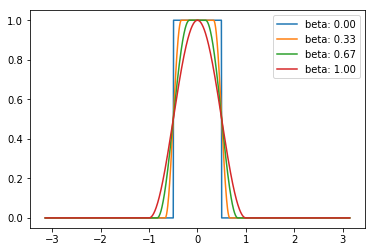

In [22]:
f = np.linspace(-np.pi, np.pi, 1000)
for b in np.linspace(1e-7, 1, 4):
    plt.plot(f, filtering.raised_cosine_response(f, period = 1, beta = b), label = 'beta: {:0.2f}'.format(b))

plt.legend();

### RC filter 的使用方式

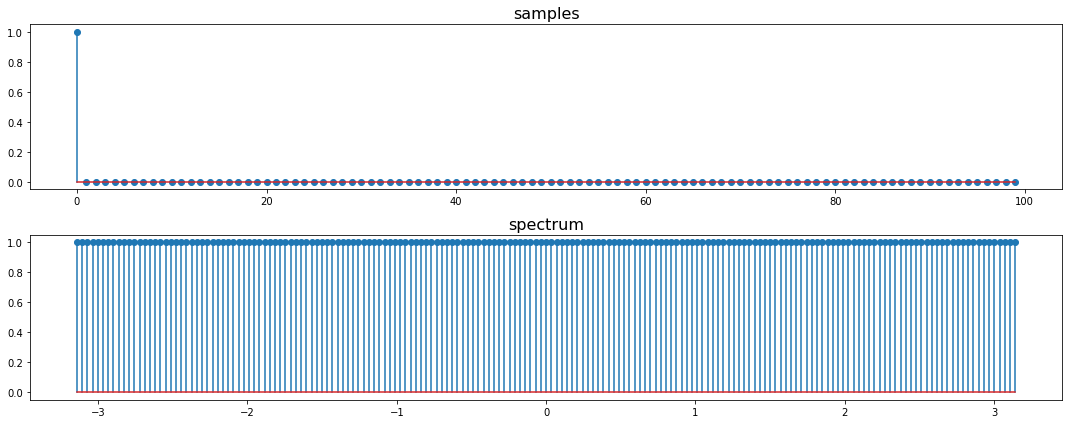

In [23]:
# Delta 訊號，全頻
delta = np.zeros(100)
delta[:1] =1
Delta = fourier.dtft(delta)

### RC 的現象
- RC impulse response 的長度只受到 指定的整數大小(N) 與 整數之間 steps_between 的影響 (N * 2 * steps_between + 1)
- RC impulse response 的長度越長，頻率響應越精確，但是越消耗效能
- 不論 RC impulse response 的長度有多長，其頻率響應都是一樣的，只跟 T (symbol period) 有關，cutoff freq = $\frac{1}{2T}$
- 把 RC 的波形 在 t = K T 的時候 = 0 (RC(KT) = 0，K和K+1中間切分 1/T等分，切得越多，對頻譜壓縮得越多。

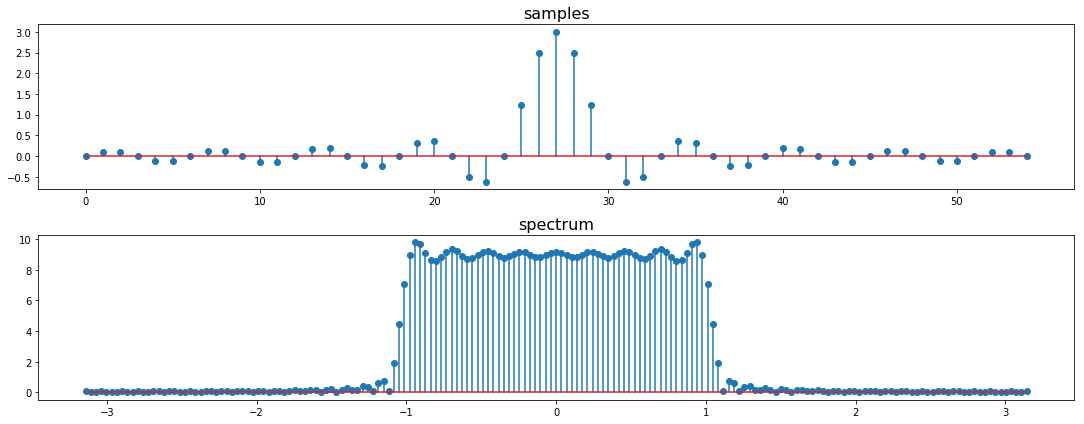

In [24]:
h = filtering.raised_cosine_fir(w_cut_ratio = 1/3)
H = fourier.dtft(h)

### 將 Delta 濾波，只剩下 $\omega_{N} = \frac{\pi}{3}$ 以內的部分

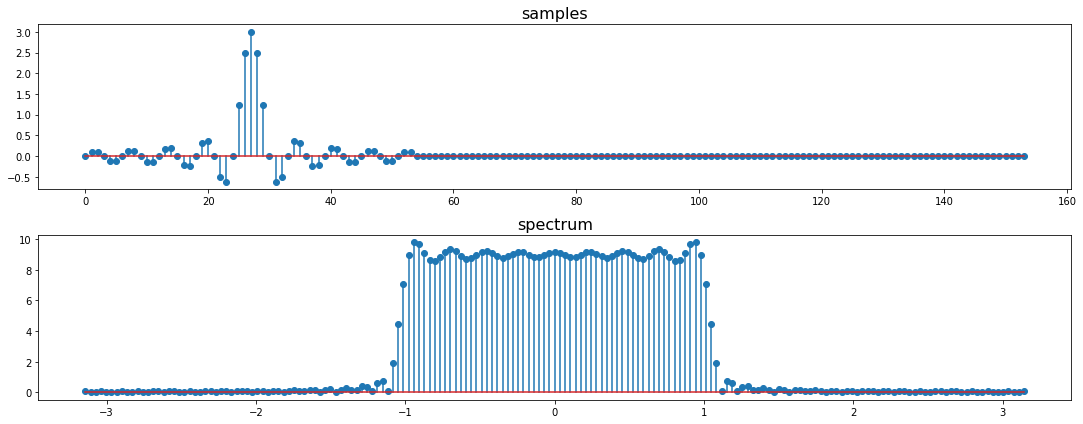

In [25]:
delta1 = np.convolve(delta, filtering.raised_cosine_fir(w_cut_ratio = 1/3))
Delta1 = fourier.dtft(delta1)

### Fit signal into channel

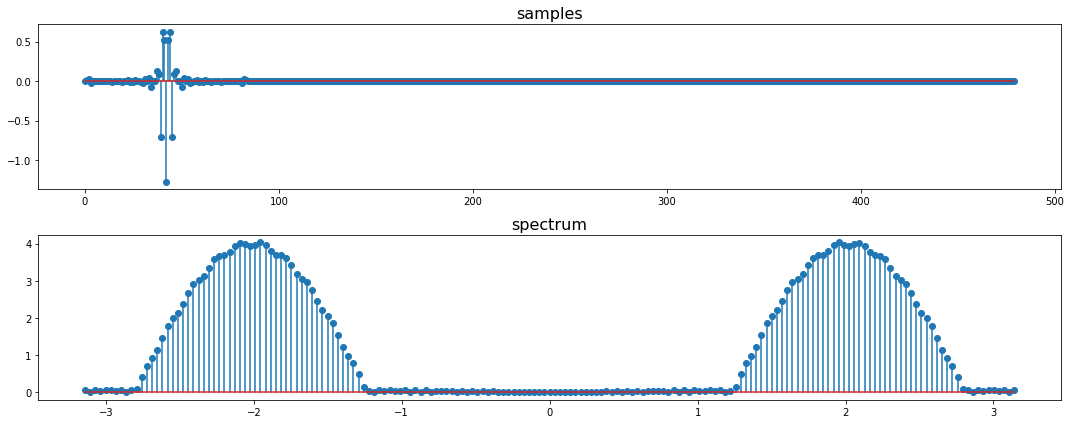

In [26]:
Fmin = 4400  # channel 允許的頻率下限
Fmax = 10000  # channel 允許的頻率上限

K, Fs, w_center, w_cut, h, signal_baseband, signal_passband = filtering.fit_spectrum(d, Fmin, Fmax)  

_ = fourier.dtft(signal_passband)

## 6.3.a Noise and probability of error

The sequence received at the receiver inevitably contains some form of noise. For each symbol, if the noise level is high, the receiver wrongly interpret the symbol for another one in the alphabet. It makes a decoding error. The probability of decoding error depends on three factors

- the signal-to-noise ratio, i.e., the power of the signal with respect to the power of the noise, SNR is expressed in dB. Through SNR, the power constraints of the channel enters in the design problem and we cannot operate at an arbitrarily high SNR
- the decoding strategy, i.e., how smart we are at circumventing the effect of noise
- the choice of alphabet. If we increase the size of the alphabet, we can transmit more information per symbol but symbols are closer in the alphabet and the probability of error increases.


## 6.3.b PAM and QAM

### PAM ([Pulse-amplitude modulation](https://en.wikipedia.org/wiki/Pulse-amplitude_modulation))

$$
\begin{align}
P_{err} &= P[\eta[n] \lt -G \space | \space nth \space bit \space = 1] + P[\eta[n] \gt G \space | \space nth-bit \space = 0] \\
 &= ( P[\eta[n] \lt -G \space ] + P[\eta[n] \gt G \space  ]) / 2 \\
 &= P[\eta[n] \gt G \space  ]  \\
 &= \int_G^{\infty} \frac{1}{\sqrt{2\pi \sigma_0^2}} e^{-\frac{\tau^2}{2\sigma_0^2}} d\tau  \\
 &= erfc(\frac{G}{\sigma_0}) \space ; \sigma_{signal}^2 = G^2 \\
 &= erfc(\frac{\sigma_{signal}}{\sigma_0})  \\
 &= erfc(\sqrt{SNR})
\end{align}
$$

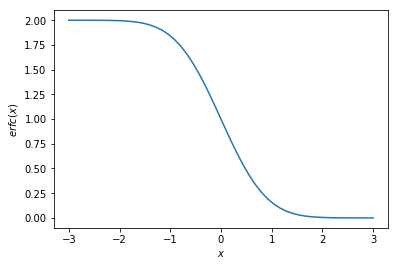

In [27]:
from scipy import special
import matplotlib.pyplot as plt
x = np.linspace(-3, 3)
plt.plot(x, special.erfc(x))
plt.xlabel('$x$')
plt.ylabel('$erfc(x)$')
plt.show()

[0 0 2 1 1 3 2 3 1 3 0 0 3 1 3 2 3 1 2 0]
[0 0 2 1 1 3 2 3 1 3 0 0 3 1 3 2 3 1 2 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True


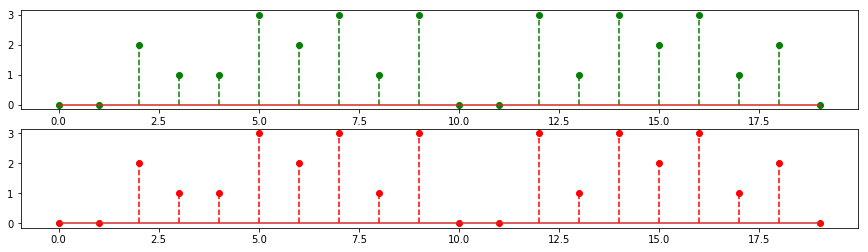

In [28]:
M = 2  # bits per symbol
values, pam_symbols, value_to_symbol, symbol_to_value = mapper.pam_mapping(M = M)

size = 20
sent_values = np.random.choice(values, size = size)

gain = 1.0
sent_symbols = gain * value_to_symbol(sent_values)

noise = np.random.randn(len(sent_symbols)) * 0.3
received_symbols = sent_symbols + noise

received_values = symbol_to_value(received_symbols) 

print(sent_values)
print(received_values)
print(received_values - sent_values)
print(np.allclose(received_values, sent_values))

plt.figure(figsize = (15, 4))
plt.subplot(2, 1, 1)
plt.stem(sent_values, linefmt = 'g--', markerfmt = 'go')
plt.subplot(2, 1, 2)
plt.stem(received_values, linefmt = 'r--', markerfmt = 'ro')
plt.show()

### QAM ([Quadrature amplitude modulation](https://en.wikipedia.org/wiki/Quadrature_amplitude_modulation))

$$
\begin{align}
\sigma_s^2 &= G^2\frac{1}{2^M} \sum_{a \in A} |a|^2 \\
&= G^2\frac{2}{3}(2^M-1) \\
\end{align}
$$


$$
\begin{align}
P_{err} &= P[|Re(\eta[n])| \gt G ] +  P[|Im(\eta[n])| \gt G ]  \\
 &= 1 - 𝑃[|𝑅𝑒(𝜂[𝑛])|\lt 𝐺 \land |𝐼𝑚(𝜂[𝑛])|\lt 𝐺] \\
 &= P[\eta[n] \gt G \space  ]  \\
 &= 1- \int_D f_{\eta}(z) dz  \\
 &\approx e^{-\frac{G^2}{\sigma_0^2}}  \\
 &\approx e^{-3\times 2^{-(M+1)}SNR}  \\
\end{align}
$$

#### Recipe: 
- pick a $P_{err}$ (e.g. $10^{-6}$)
- find the SNR imposed by the channel's power constrain
- $M = log_2(1-\frac{3}{2}\frac{SNR}{ln(P_{err})})$
- final throughput = MW

[1079  161 2159 1767 3995 1680 2680 2554 1298 3373  883 1498 1924  198
 3215 2821 1127 1040 1181 1229]
[1079  161 2159 1767 3995 1680 2680 2554 1298 3373  883 1498 1924  198
 3215 2821 1127 1040 1181 1229]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True


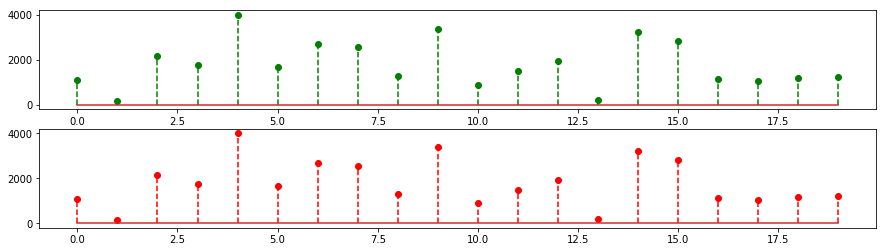

In [29]:
M = 12  # bits per symbol
values, qam_symbols, value_to_symbol, symbol_to_value = mapper.qam_mapping(M = M)

size = 20
sent_values = np.random.choice(values, size = size)

gain = 1.0
sent_symbols = gain * value_to_symbol(sent_values)

noise = (np.random.randn(len(sent_symbols)) + 1j* np.random.randn(len(sent_symbols))) * 0.3
received_symbols = sent_symbols + noise
received_values = symbol_to_value(received_symbols) 

print(sent_values)
print(received_values)
print(received_values - sent_values)
print(np.allclose(received_values, sent_values))

plt.figure(figsize = (15, 4))
plt.subplot(2, 1, 1)
plt.stem(sent_values, linefmt = 'g--', markerfmt = 'go')
plt.subplot(2, 1, 2)
plt.stem(received_values, linefmt = 'r--', markerfmt = 'ro')
plt.show()

## 6.4.a Modulation and demodulation


### passband signal
$$
\begin{align}
s[n] &= Re\{b[n]e^{j\omega_cn} \}  \\
&= Re\{(b_r[n] + jb_i[n]) (cos(\omega_c n) + jsin(\omega_c n) \}  \\
&= b_r[n]cos(\omega_c n) - b_i[n]sin(\omega_c n)  \\ 
\end{align}
$$

### recovery of baseband signal
$$
\begin{align}
s[n]cos(\omega_c n) &= b_r[n]cos(\omega_c n)cos(\omega_c n) - b_i[n]sin(\omega_c n)cos(\omega_c n)  \\ 
&=b_r[n]\frac{1+cos(2\omega_c n)}{2} - b_i[n]\frac{sin(2\omega_c n)}{2} \\
&= \frac{1}{2}b_r[n] +  \frac{1}{2}(b_r[n]cos(2\omega_c n) - b_i[n]sin(2\omega_c n))  \\
\\
s[n]sin(\omega_c n) &= b_r[n]cos(\omega_c n)sin(\omega_c n) - b_i[n]sin(\omega_c n)sin(\omega_c n)  \\ 
&=b_r[n]\frac{sin(2\omega_c n)}{2} - b_i[n]\frac{1+cos(2\omega_c n)}{2} \\
&= -\frac{1}{2}b_i[n] +  \frac{1}{2}(b_r[n]sin(2\omega_c n) - b_i[n]cos(2\omega_c n))  \\
\end{align}
$$

## 6.4.b Design example

In [30]:
Fmin = 450
Fmax = 2850
(Fmin, Fmax, bandwidth, F_center,  F_cut), (W, K, Fs, Ts, F_nyquist), freq_to_pi, (w_min, w_max, w_center, w_cut) = \
    dsp.parse_bandwidth(Fmin, Fmax)

(Fmin, Fmax, F_center, bandwidth, F_cut), (W, K, Fs, Ts, F_nyquist), freq_to_pi, (w_min, w_max, w_center, w_cut)

In [31]:
w_center/np.pi

In [32]:
SNR_dB = 22
Perr = 1e-6
M = mapper.get_M(SNR_dB, Perr)
M 

In [33]:
W = 2400
C = dsp.channel_capacity(W, SNR_dB)
C

### Transmit

#### original signal

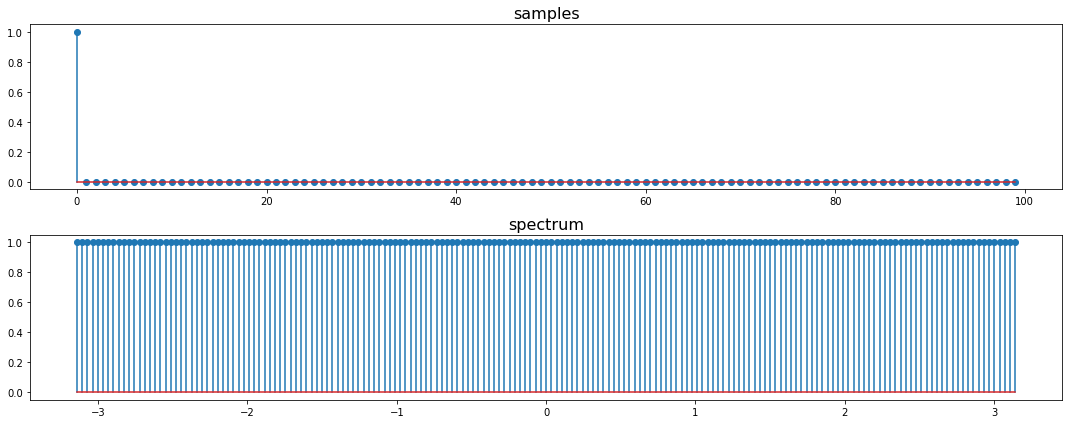

In [34]:
# Delta 訊號，全頻
delta = np.zeros(100)
delta[:1] =1
Delta = fourier.dtft(delta)

#### mapper

In [35]:
# a = mapper.qam_mapping()

#### up sampling
#### low-pass
#### modulate to passband

In [36]:
(Fmin, Fmax, F_center, bandwidth, F_cut, F_nyquist)

In [37]:
a = delta 
K, Fs, w_center, w_cut, h, signal_baseband, signal_passband = filtering.fit_spectrum(a, Fmin, Fmax)

#### baseband signal

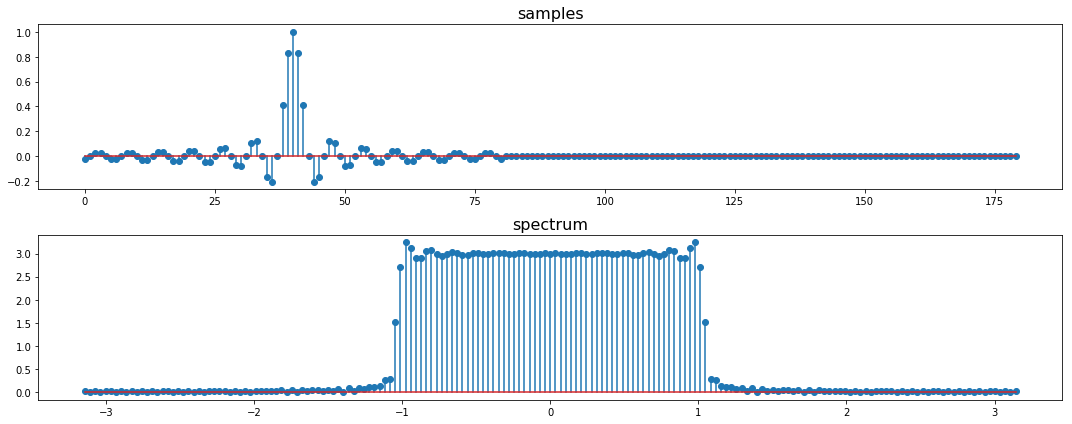

In [38]:
_ = fourier.dtft(np.convolve(a, h))

#### passband signal

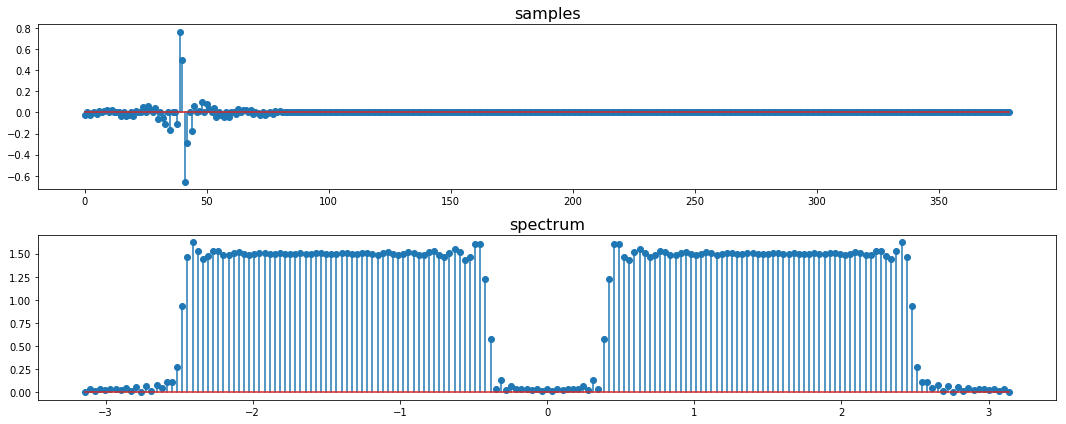

In [39]:
_ = fourier.dtft(signal_passband)

### Receiving

#### demodulate to baseband

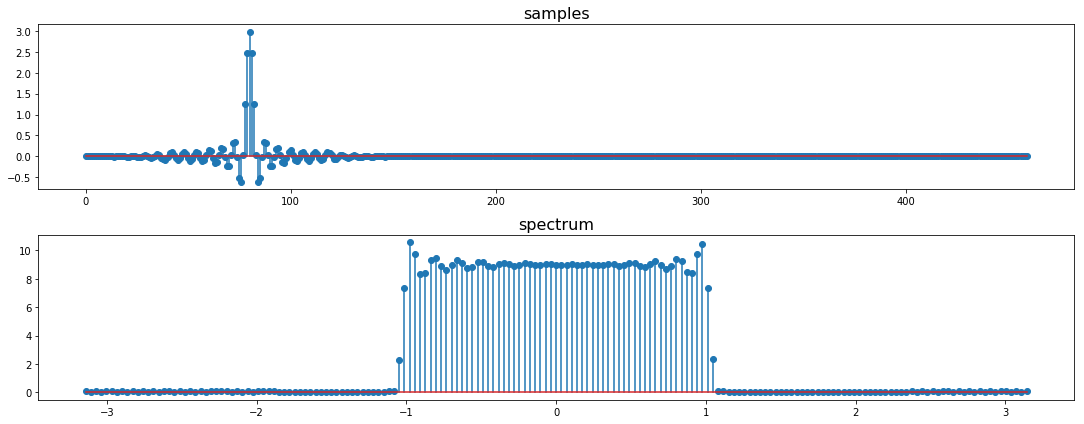

In [40]:
signal_baseband = filtering.demodulate_passband_to_baseband(signal_passband, w_center, h = h, w_cut = None)
# signal_baseband = filtering.demodulate_passband_to_baseband(signal_passband, w_center,  w_cut = w_cut)
_ = fourier.dtft(signal_baseband)

#### down sampling

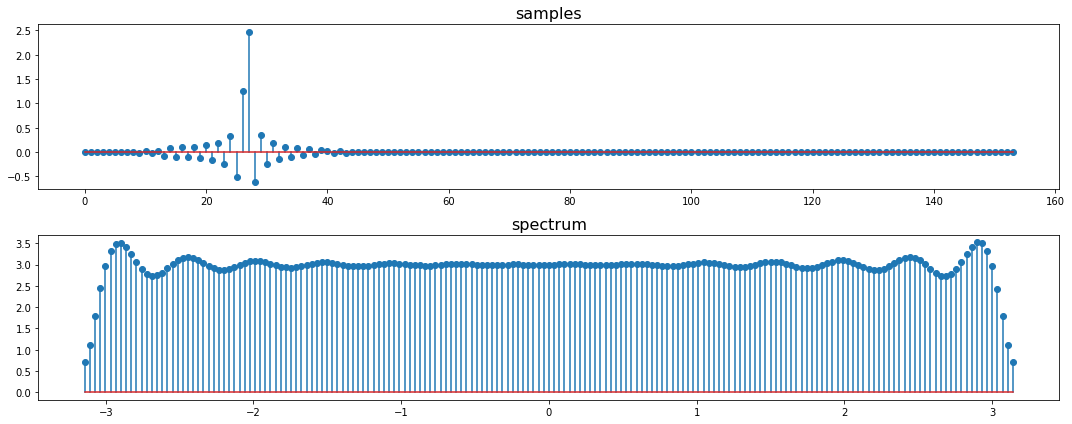

In [41]:
_ = fourier.dtft(multirate.downsample(signal_baseband, K))

#### mapper from symbols to values

## Frequency-Shift Keying (FSK)

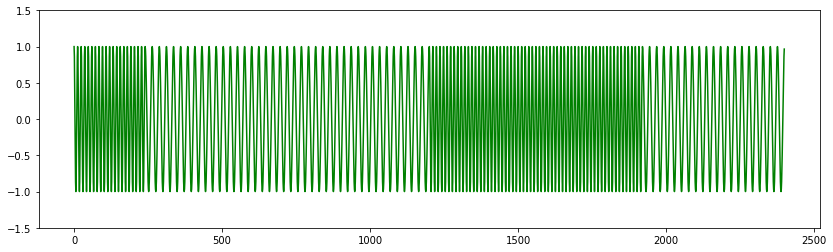

In [42]:
Fs = 24000
BITS = 500
b = np.sign(np.random.randn(BITS, 1))

BPS = 100             #  bits per second 
SPB = int(Fs / BPS)   #  samples per bit 

x = filtering.fsk(b, freq_mapping = {-1: 1000, 1: 2000}, Fs = Fs, bits_per_second  = BPS)

plt.figure(figsize=(14,4))
plt.plot(x[0:SPB*10], 'green')
plt.ylim([-1.5, 1.5]);

IPython.display.Audio(x, rate=Fs)

## 6.5.b Delay compensation

Receiver 的 clock 不一定和 transmitter 一致，所以接收到訊號之後做 sampling 出來的 samples 會和原本發送方的 samples 不一致，所以要估計 delay 以便 receiver 可以修正取樣的值，以便可以還原原本的訊號。

Total delay $d = (b + \tau) Ts$：
- b: bulk delay: just set the maximum sampled peak as $n = 0$
- $\tau$: fractional delay 需要藉由雙方已經知道的頻率來溝通測量

### Estimating the fractional delay

Transmitter: 
$$
\begin{align}
b[n] &= e^{j\omega_0 n }  \\
s[n] &= cos((\omega_c + \omega_0) n ))  \\
\end{align}
$$

Receiver: 
$$
\begin{align}
\hat{s}[n] &= cos((\omega_c + \omega_0)(n - b - \tau))  \\
\end{align}
$$

after demodulation and buld delay offset: 
$$
\begin{align}
\hat{b}[n] &= e^{j\omega_0(n-\tau)}  \\
\end{align}
$$


multiply by known frequency: 
$$
\begin{align}
\hat{b}[n] e^{-j\omega_0 n} &= e^{j\omega_0(n-\tau)} e^{-j\omega_0 n}  \\
&= e^{-j\omega_0(\tau - n)} e^{-j\omega_0 n} \\
&= e^{-j\omega_0 \tau}  \\
\end{align}
$$

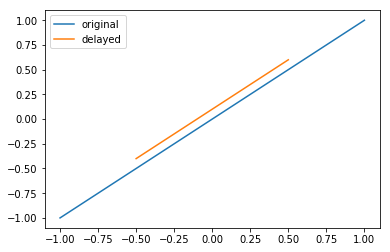

In [43]:
t = np.linspace(-1, 1, 5)

# x = np.sin(t)
x = t
tau = 0.2

li = Lagrange()
x_delayed = li.fractional_delay(x, tau = tau)

plt.plot(t, x, label = 'original');
plt.plot(t, x_delayed, label = 'delayed')
plt.legend();

## 6.5.c Adaptive equalization

## 6.6.a ADSL design
Center frequency of each subchannel:
$$
\omega_k = 2\pi \frac{\frac{kF_{max}}{N}}{F_s} = \frac{2\pi}{2N}k \\
$$

Bandwidth of each subchannel:
$$
 \frac{2\pi}{2N} \\
$$

To send symbols over a subchannle: upsampling factor $K \geq 2N$

## 6.6.b Discrete multitone modulation

$$
\begin{align}
a_k[\lfloor \frac{n}{2N} \rfloor] \times e^{j(\frac{2\pi}{2N})n k } &= c_k[n]  \\
 c_k[n] &= \sum_{k=0}^{N-1} a_k[\lfloor \frac{n}{2N} \rfloor] \times e^{j(\frac{2\pi}{2N})n k }   \\
 &= 2N \times IDFT_{2N}\{[a_0[m], a_1[m],...,a_{N-1}[m],0,0,...,0] \}[n] & (m = \lfloor \frac{n}{2N} \rfloor ) \\
\\
IDFT\{[x_0, x_1, x_2,...,x_{N-2}, x_{N-1}] \}^* &= IDFT\{[x_0, x_{N-1},x_{N-2},...,x_2,x_1 ]^* \} \\
s[n] &= Re\{c[n]\} = (c[n] + c^*[n]) / 2  \\
&= N \times IDFT\{[a_0[m], a_1[m],...,a_{N-1}[m],0,0,...,0] \}[n] + N \times IDFT_{2N}\{[a_0^*[m], ,0,0,...,0,a_{N-1}^*[m],...,a_1^*[m]] \}[n]  \\
&= N \times IDFT\{[2a_0[m], a_1[m],...,a_{N-1}[m],a_{N-1}^*[m],...,a_1^*[m]] \}[n] \\
\end{align}
$$  

